In [4]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Input

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

In [5]:
logdir = "logs"

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Reshape the images to include a channel dimension
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize the images to be in the range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define class labels
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [7]:
# Compile the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x=train_images,
          y=train_labels,
          epochs=5,
          validation_data=(test_images, test_labels))

# Generate true labels and model predictions
y_true = test_labels
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Compute confusion matrix
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

# Normalize confusion matrix
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

# Convert confusion matrix to DataFrame for visualization
con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 68s 35ms/step - accuracy: 0.8914 - loss: 0.3458 - val_accuracy: 0.9824 - val_loss: 0.0515
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.9852 - loss: 0.0465 - val_accuracy: 0.9862 - val_loss: 0.0435
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9900 - loss: 0.0327 - val_accuracy: 0.9883 - val_loss: 0.0338
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9922 - loss: 0.0250 - val_accuracy: 0.9901 - val_loss: 0.0301
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9948 - loss: 0.0168 - val_accuracy: 0.9920 - val_loss: 0.0289
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


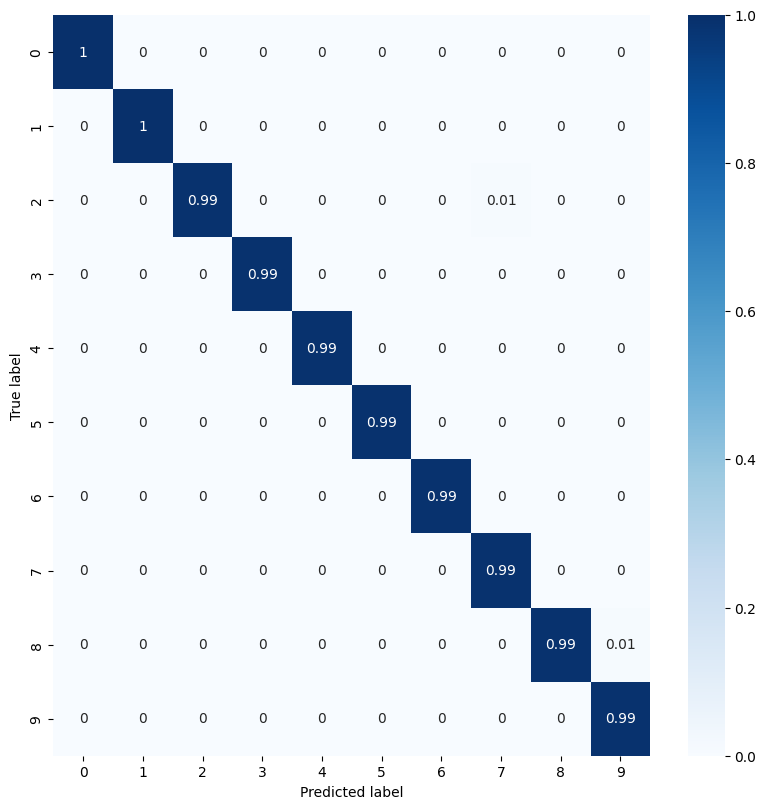

In [8]:
# Plot the confusion matrix using seaborn heatmap
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [9]:
def calculate_metrics(confusion_matrix):
    """Extract values from the confusion matrix"""

    TP = np.diag(confusion_matrix)  # True Positives (diagonal values)
    FP = confusion_matrix.sum(axis=0) - TP  # False Positives (column sum minus TP)
    FN = confusion_matrix.sum(axis=1) - TP  # False Negatives (row sum minus TP)
    TN = confusion_matrix.sum() - (FP + FN + TP)  # True Negatives (total - FP - FN - TP)

    sensitivity = TP / (TP + FN)

    specificity = TN / (FP + TN)

    precision = TP / (TP + FP)

    accuracy = (TP + TN) / confusion_matrix.sum()

    f_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    # Handle cases where division by zero may occur
    sensitivity = np.nan_to_num(sensitivity)
    specificity = np.nan_to_num(specificity)
    precision = np.nan_to_num(precision)
    f_score = np.nan_to_num(f_score)

    return sensitivity, specificity, accuracy, precision, f_score

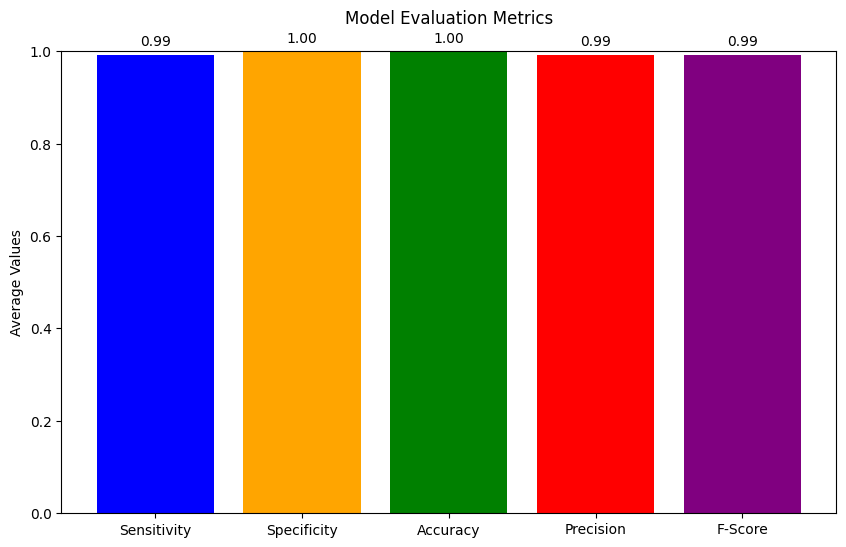

In [15]:
sensitivity, specificity, accuracy, precision, f_score = calculate_metrics(con_mat)

metrics = {
    "Sensitivity": sensitivity.mean(),
    "Specificity": specificity.mean(),
    "Accuracy": accuracy.mean(),
    "Precision": precision.mean(),
    "F-Score": f_score.mean()
}

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title("Model Evaluation Metrics", pad=20)
plt.ylabel("Average Values")
plt.ylim(0, 1)
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()